## The aim of this notebook is to generate the graphs that appear in the streamlit application

This is only a fraction of the code used in the actual project, and these graphs serve to showcase some of the work done in the project. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium

/Users/abohane/Desktop/docker-streamlit/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
df_train = pd.read_parquet("train.parquet")
df_test = pd.read_parquet("test.parquet")

# Merge both datasets in order
df_all = pd.concat([df_train, df_test])

In [4]:
# Group by 'site_name' and sum 'log_bike_count'
grouped_counts = df_all.groupby(['site_name'])['log_bike_count'].sum().reset_index()

# Merge the summed counts back into the original DataFrame
df_all = df_all.merge(grouped_counts, on='site_name', suffixes=('', '_sum_total'))

/var/folders/61/n2sfq6s16zdgx5_xwt6gtdvr0000gn/T/ipykernel_45731/2356001827.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_counts = df_all.groupby(['site_name'])['log_bike_count'].sum().reset_index()


In [14]:
import matplotlib.colors as mcolors
from folium.plugins import FloatImage


min_count = df_all['log_bike_count_sum_total'].min()
max_count = df_all['log_bike_count_sum_total'].max()
norm = mcolors.Normalize(vmin=min_count, vmax=max_count, clip=True)

# Create a colormap
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.gnuplot)

# Create the map
m = folium.Map(location=df_all[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

# Loop to create markers with color based on 'log_bike_count_sum'
for _, row in (
    df_all[["site_name", "latitude", "longitude", "log_bike_count_sum_total"]]
    .drop_duplicates("site_name")
    .iterrows()
):
    color = mcolors.to_hex(mapper.to_rgba(row['log_bike_count_sum_total']))
    folium.CircleMarker(
        location=row[["latitude", "longitude"]].values.tolist(),
        popup=row["site_name"],
        radius=10,
        color=color,
        fill=True,
        fill_color=color
    ).add_to(m)

/Users/abohane/Desktop/docker-streamlit/.venv/lib/python3.9/site-packages/folium/utilities.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


In [8]:
# save file as html
m.save('saved_map.html')

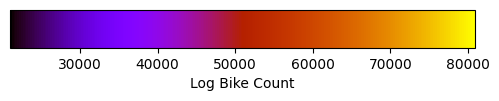

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def save_colorbar():
    # Create a figure and a single subplot
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    # Define the colormap and norm to use for the colorbar
    cmap = plt.cm.gnuplot
    norm = mcolors.Normalize(vmin=min_count, vmax=max_count)

    # Create a ScalarMappable and associate it with the norm and colormap
    scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

    # Create the colorbar
    cb = fig.colorbar(scalar_mappable, cax=ax, orientation='horizontal')
    cb.set_label('Log Bike Count')

    # Save the colorbar to a file
    plt.savefig('colorbar.png', bbox_inches='tight')

save_colorbar()


/var/folders/61/n2sfq6s16zdgx5_xwt6gtdvr0000gn/T/ipykernel_45731/2029664604.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/61/n2sfq6s16zdgx5_xwt6gtdvr0000gn/T/ipykernel_45731/2029664604.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday'])


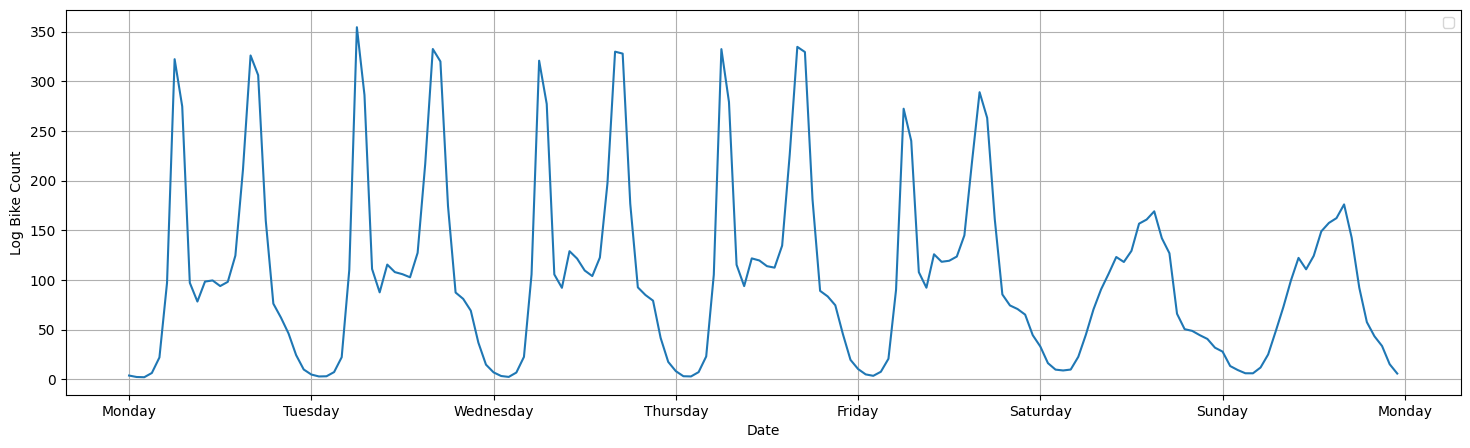

In [38]:
fig, ax = plt.subplots(figsize=(18, 5))

# Define the time frame
start_date = pd.to_datetime("2020/09/14")
end_date = pd.to_datetime("2020/09/21")

# Apply the same date filter to the entire dataset for calculating the average
mask_timeframe = (df_all["date"] >= start_date) & (df_all["date"] < end_date)
average_counts = df_all[mask_timeframe].groupby('date')['bike_count'].mean()


plt.plot(average_counts)

# Adding legend and labels
ax.legend()
ax.grid()
ax.set_xlabel('Date')
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday'])
ax.set_ylabel('Log Bike Count')
plt.savefig('week_count.png', bbox_inches='tight')


In [ ]:
info_df = pd.DataFrame({
    'Column': df_all.columns,
    'Value Count': df_all.count(),
    'Unique': df_all.nunique(),
    'Dtype': df_all.dtypes,
}).reset_index(drop=True)


In [41]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X

df_fe = _encode_dates(df_all)



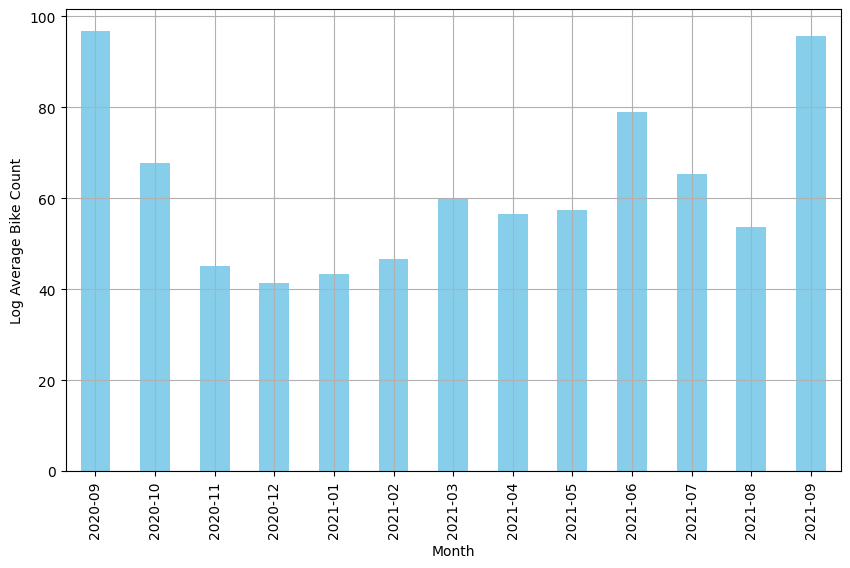

In [45]:
# Create a 'year-month' column for chronological sorting
df_fe['year_month'] = pd.to_datetime(df_fe['year'].astype(str) + '-' + df_fe['month'].astype(str))

# Calculate the mean bike count for each 'year-month'
average_monthly_counts = df_fe.groupby('year_month')['bike_count'].mean()

# Plotting
plt.figure(figsize=(10, 6))
average_monthly_counts.plot(kind='bar', color='skyblue')
# plt.title('Scaled Average Bike Count for Each Month Over Time')
plt.xlabel('Month')
plt.ylabel('Log Average Bike Count')

x_labels = [date.strftime('%Y-%m') for date in average_monthly_counts.index]
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=90)


plt.grid()

plt.savefig('month_count.png', bbox_inches='tight')